In [38]:
import pydicom
import scipy
from scipy.optimize import least_squares, minimize

from data_structures.ct_image import CTImage
from utils import *

In [39]:
reference_image_path = "data_2/Project/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm"
patient_image_path = "data_2/Project/RM_Brain_3D-SPGR/"

Let's load reference image first and visualize it. The goal is not to change anything in the reference image and i will try to tweak/change input image for the purpose of coregistration.

In [81]:
reference_image = pydicom.dcmread(reference_image_path)
reference_image.pixel_array.shape

(193, 229, 193)

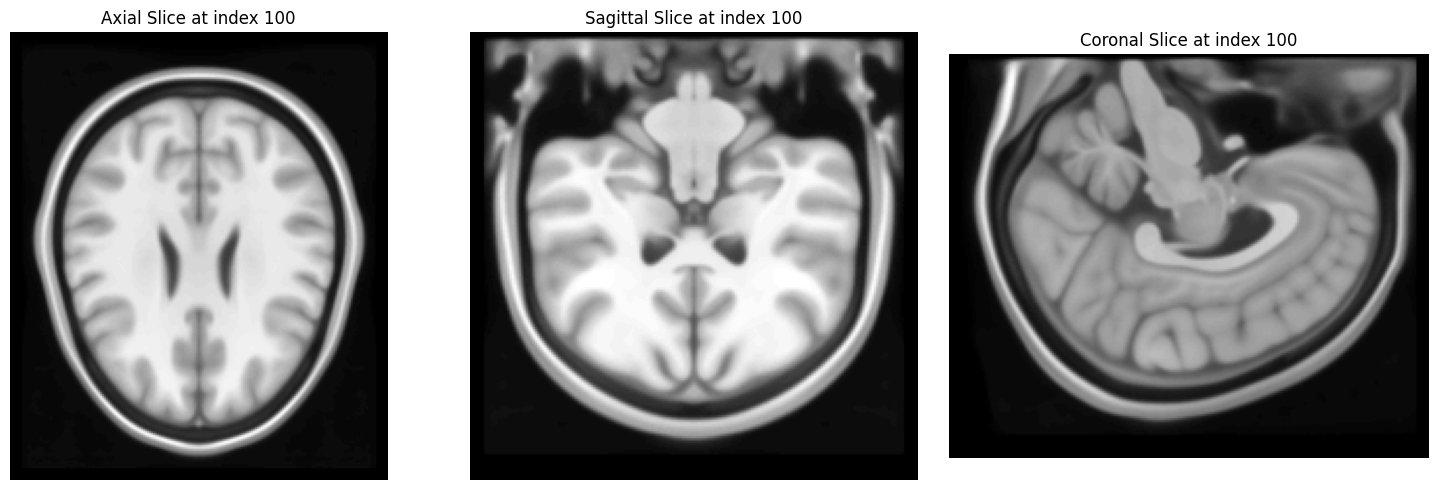

In [82]:
visualize_slices(reference_image.pixel_array, 100, 100, 100)

We need to extract pixel spacing information from the headers of reference image so that we can use it to scal input image later.

In [43]:
# Access the Shared Functional Groups Sequence
shared_functional_groups_sequence = reference_image.get((0x5200, 0x9229), None)

if shared_functional_groups_sequence:

    for item in shared_functional_groups_sequence:
        pixel_measures_sequence = item.get((0x0028, 0x9110), None)

        if pixel_measures_sequence:
            pixel_spacing = pixel_measures_sequence[0].get((0x0028, 0x0030), None)
            print("Pixel Spacing:", pixel_spacing)

Pixel Spacing: (0028, 0030) Pixel Spacing                       DS: [1, 1]


Now, I will use my developed data structure to load CT image of brain and make a pixel array that will be used for computations later. Here I will also examine the pixel spacing and make required changes to scale the image to make it compatible with reference one, so we won't face any issue later in the process of coregistration.

In [44]:
patient_image = CTImage()
patient_image.load_data(patient_image_path)
patient_image.make_3d_array()

In [45]:
patient_image.pixel_array.shape

(212, 512, 512)

In [46]:
patient_image.slices[0].pixel_spacing

[0.5078, 0.5078]

Rescaling input image using pixel spacing information.

In [47]:
patient_image.rescale_image(target_spacing=[1, 1, 1], original_spacing=[0.5078, 0.5078, 0.5078])
patient_image.pixel_array.shape

(108, 260, 260)

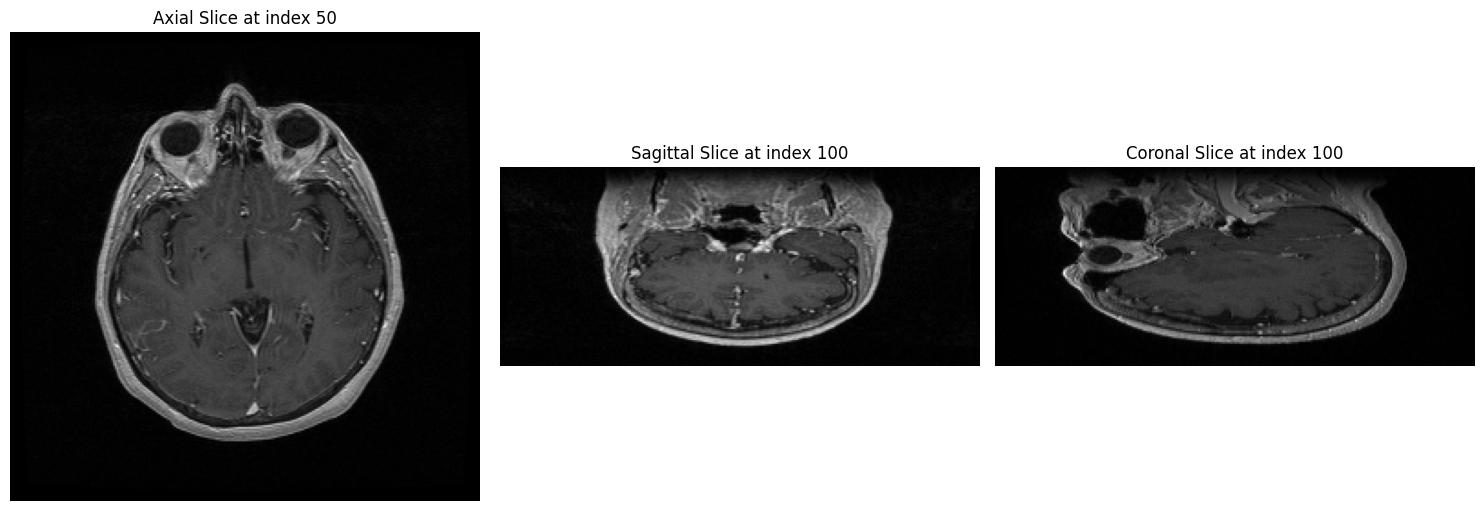

In [48]:
patient_image.visualize_slices(50,100,100)

In [49]:
patient_image.crop_image(reference_image.pixel_array.shape)
patient_image.pixel_array.shape

(108, 229, 193)

In [50]:
patient_image.interpolate_slices(193)
patient_image.pixel_array.shape

(193, 229, 193)

Now, we have cropped the image and with some changes it is equal to the size of reference, let's visualize.

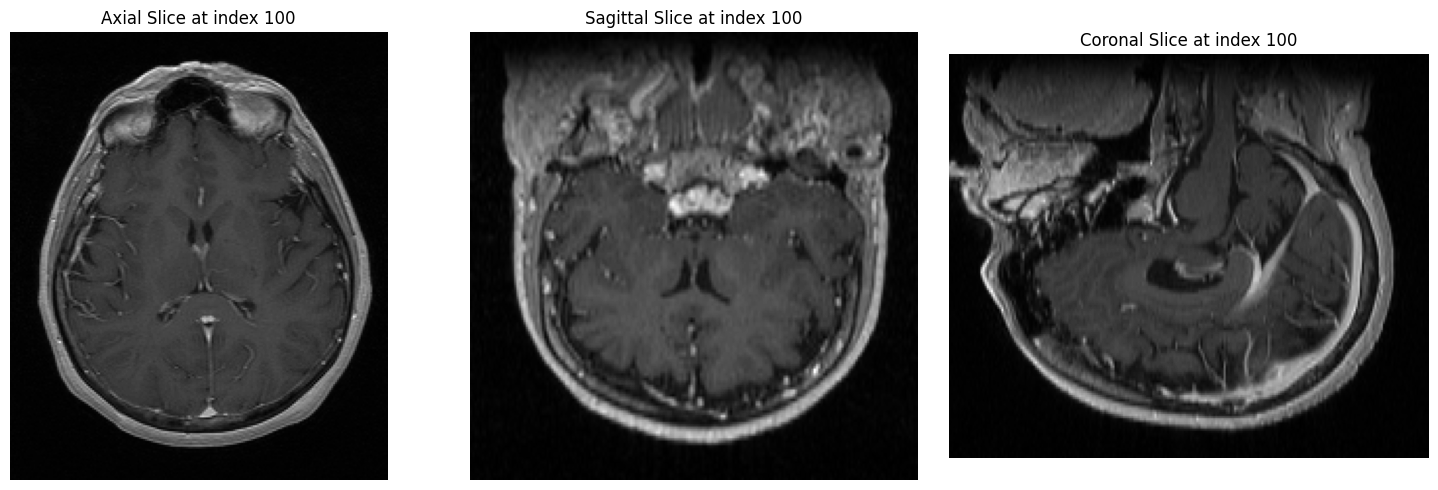

In [51]:
patient_image.visualize_slices(100, 100, 100)

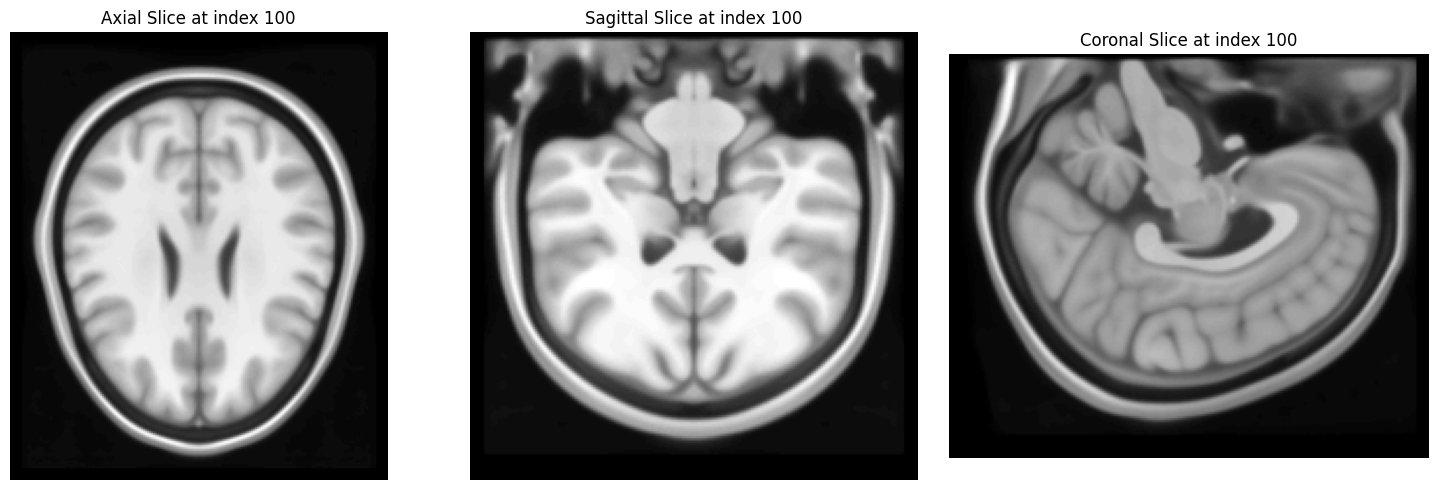

In [52]:
visualize_slices(reference_image.pixel_array, 100, 100, 100)

Both of the images are upside down, let's flip them on the first axis so that we can have head (upper side/hair side) facing upwards in the sagittal and coronal planes.

In [53]:
reference_image_flipped = np.flip(reference_image.pixel_array, axis=0)
patient_image.pixel_array = np.flip(patient_image.pixel_array, axis=0)

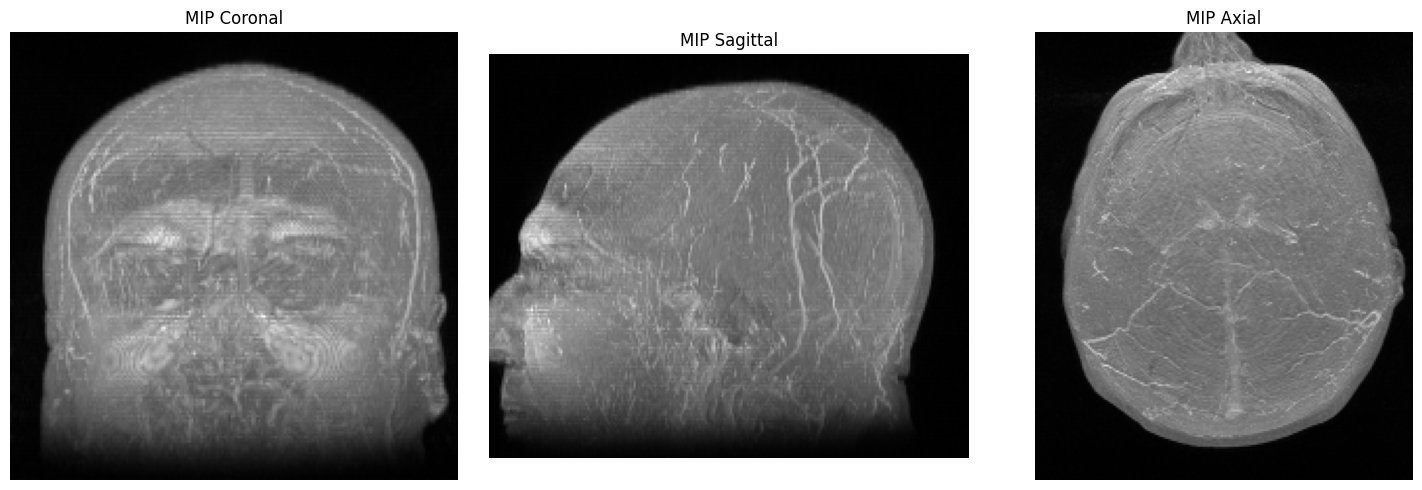

In [54]:
patient_image.visualize_all_projections_mip()

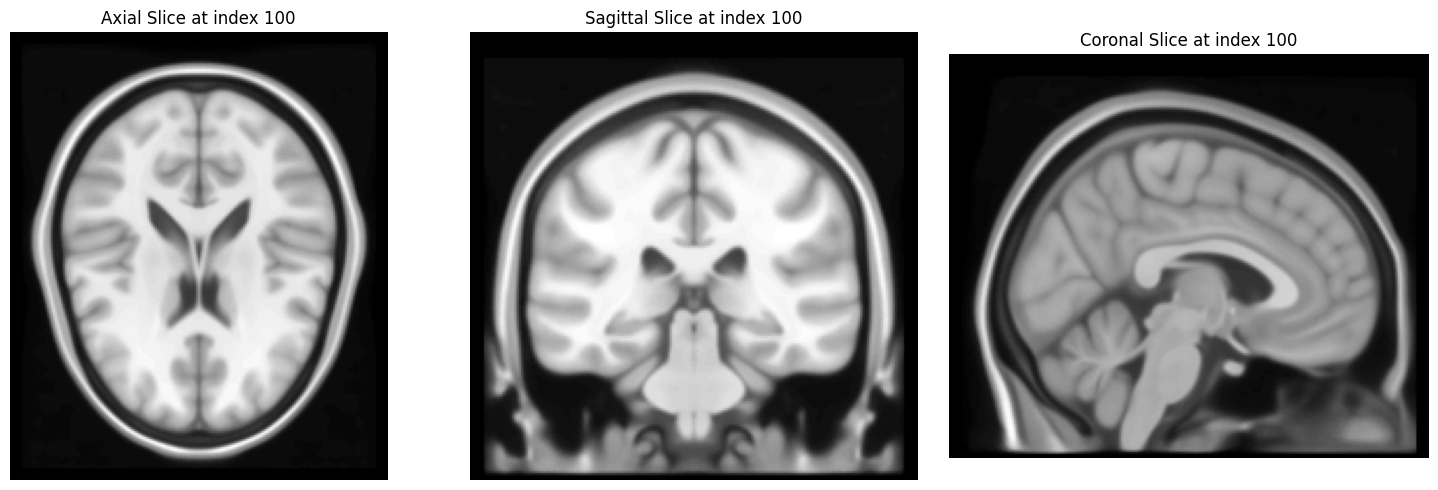

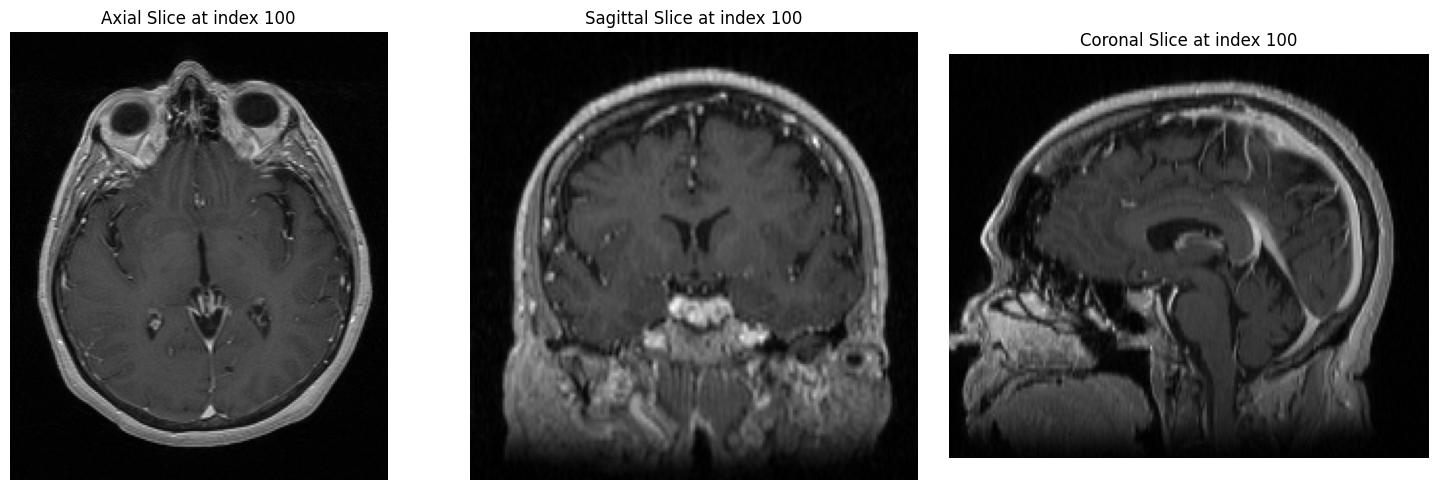

In [55]:
visualize_slices(reference_image_flipped, 100, 100, 100)
patient_image.visualize_slices(100, 100, 100)

In [56]:
print(patient_image.pixel_array.shape)
print(reference_image.pixel_array.shape)

(193, 229, 193)
(193, 229, 193)


All the preprocessing is done. Now we can safely procees with coregistration.

## Coregistraion

In [57]:
def rigid_transformation(image, parameters):
    """
    This function takes image and parameters(translation and angles) as input and perform rigid transformation.
    """

    t1, t2, t3, angle1, angle2, angle3 = parameters

    translated_image = np.roll(image, np.array(parameters[0:3]).astype(int), axis=(0, 1, 2))
    # Axial first
    image = scipy.ndimage.rotate(translated_image, (180/np.pi) * angle1, axes=(1, 2), reshape=False)
    image = scipy.ndimage.rotate(image, (180/np.pi) * angle2, axes=(0, 2), reshape=False)
    image = scipy.ndimage.rotate(image, (180/np.pi) * angle3, axes=(0, 1), reshape=False)

    return image

In [58]:
def mse(ref_img, inp_img):
    """
    Calculates the MSE between two images.
    """
    return np.mean((ref_img-inp_img)**2)

def normalize(input_array):
    """
    Normalizing image pixel values.
    """
    min_val = np.min(input_array)
    max_val = np.max(input_array)
    normalized_array = (input_array - min_val) / (max_val - min_val)
    return normalized_array

def find_centroid_volume(volume):
    """
    Finding centroid of the volume.
    """
    idcs = np.where(volume != 0)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid

In [59]:
def coregister_image(ref_image: np.ndarray, inp_image: np.ndarray, optimizer="GD"):
    """ Coregister two sets of landmarks using a rigid transformation. """

    errors = []

    center_ref = find_centroid_volume(ref_image)
    center_inp = find_centroid_volume(inp_image)

    translation_vector = center_inp - center_ref

    initial_parameters = [
        translation_vector[0], translation_vector[1], translation_vector[2],    # Translation vector
        np.pi, 0, 0         # In radians
    ]

    def function_to_minimize(parameters):
        input_image = rigid_transformation(inp_image, parameters)
        error = mse(ref_image, input_image)
        errors.append(error)
        return error


    if optimizer == "GD":
        # Apply gradient descent optimization
        result = minimize(
            function_to_minimize,
            x0=initial_parameters)
    else:
        # Apply least squares optimization
        print( initial_parameters)
        result = least_squares(
            function_to_minimize,
            x0=initial_parameters,
            max_nfev=50,
            verbose=2)
    return result, errors

In [60]:
# least squares
result, errors = coregister_image(normalize(reference_image_flipped), normalize(patient_image.pixel_array), "LS")

In [ ]:
result.x

In the following cell, i have hard coded the parameters that i found after running optimization. Reason of hard coding is that it takes long time for optimization algorithm to converge and i can't wait everytime i run notebook.

In [61]:
parameters = [ 5.43924265e+00, -1.64225154e+00,  6.07740084e-04,  3.15204358e+00,
        5.83826094e-02, -3.69148538e-02]


In [62]:
coregistered_input = rigid_transformation(patient_image.pixel_array, parameters)

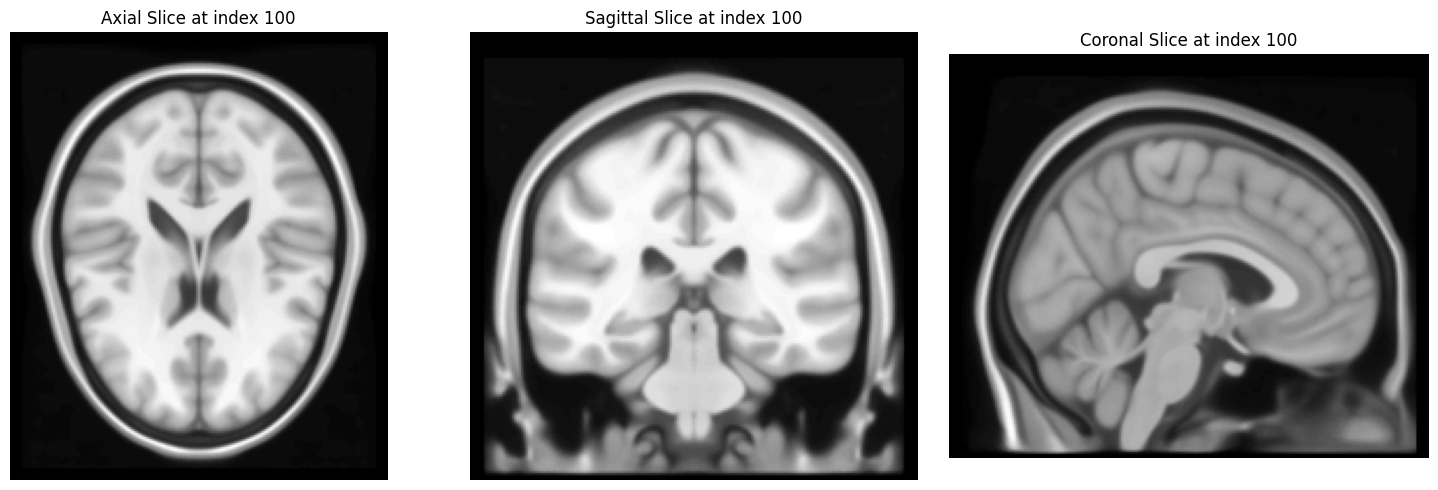

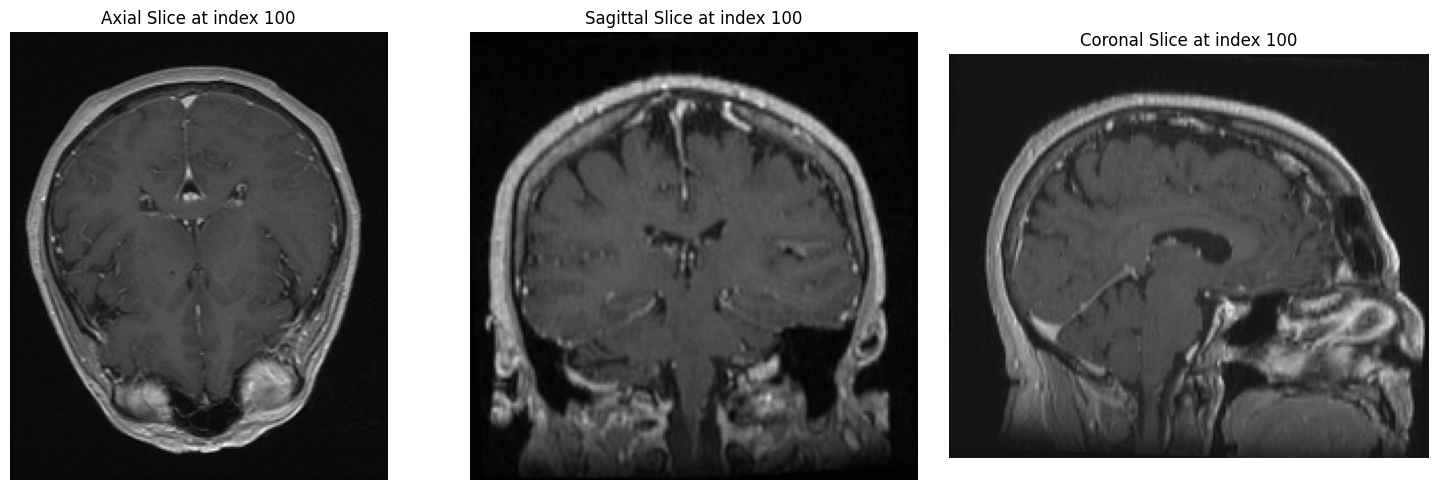

In [63]:
visualize_slices(reference_image_flipped, 100, 100, 100)
visualize_slices(coregistered_input, 100, 100, 100)

## Thalamus Region

In [64]:
patient_image.pixel_array.shape

(193, 229, 193)

In [65]:
atlas_path = "./data_2/Project/AAL3_1mm.dcm"
atlas = pydicom.dcmread(atlas_path)

In [66]:
atlas.pixel_array.shape

(181, 217, 181)

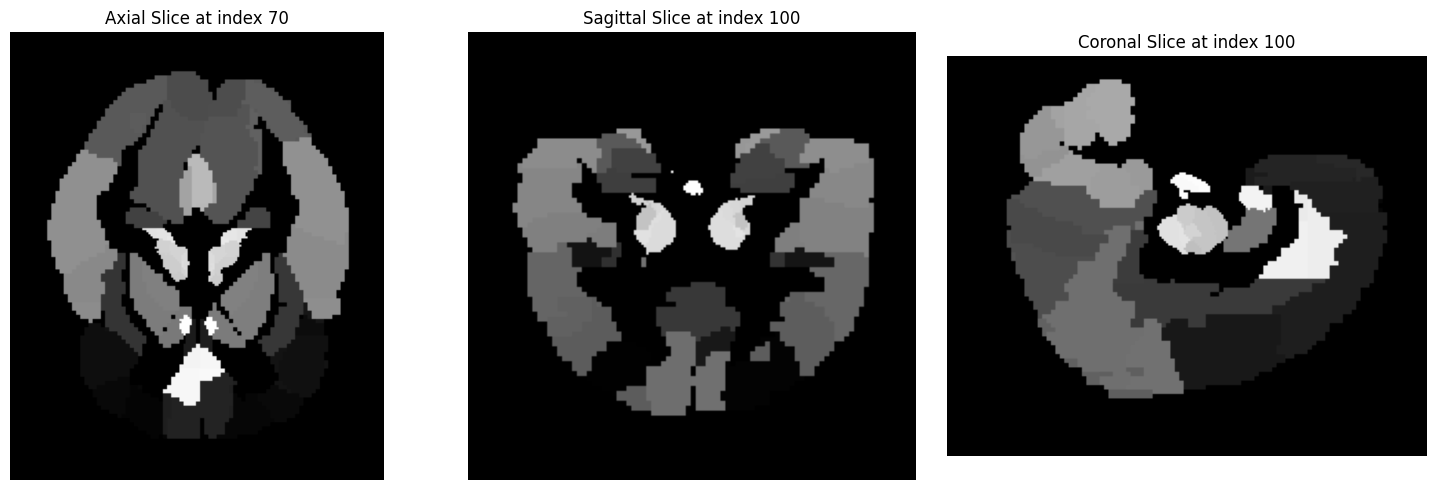

In [67]:
visualize_slices(atlas.pixel_array, 70, 100, 100)

In [70]:
def inverse_rigid_transformation(image, parameters):
    """
    Inverse transformation from the reference space to the input based on provided parameters
    """
    t1, t2, t3, angle1, angle2, angle3 = parameters

    image = scipy.ndimage.rotate(image, -(180/np.pi) * angle3, axes=(0, 1), reshape=False, order=3)
    image = scipy.ndimage.rotate(image, -(180/np.pi) * angle2, axes=(0, 2), reshape=False, order=3)
    image = scipy.ndimage.rotate(image, -(180/np.pi) * angle1, axes=(1, 2), reshape=False, order=3)

    translated_image = np.roll(image, -np.array([t1, t2, t3]).astype(int), axis=(0, 1, 2))

    return translated_image

In [71]:
def get_thalamus_mask(img_atlas: np.ndarray) -> np.ndarray:
    """
    return the thalamus mask based on "thal-" prefix values.
    """
    # get the thalamus region
    mask = np.zeros_like(img_atlas)
    for i in range(121, 151):
        mask[img_atlas == i] = 1
    return mask

def visualize_axial_slice(
        img: np.ndarray,
        mask: np.ndarray,
        mask_centroid: np.ndarray,
        dim=0
        ):
    """ Visualize the axial slice (firs dim.) of a single region with alpha fusion. """
    img_slice = img[mask_centroid[dim].astype('int'), :, :]
    mask_slice = mask[mask_centroid[dim].astype('int'), :, :]

    cmap = matplotlib.cm.get_cmap('bone')
    norm = matplotlib.colors.Normalize(vmin=np.amin(img_slice), vmax=np.amax(img_slice))
    fused_slice = \
        0.7*cmap(norm(img_slice))[..., :3] + \
        0.3*np.stack([mask_slice, np.zeros_like(mask_slice), np.zeros_like(mask_slice)], axis=-1)
    plt.imshow(fused_slice)
    plt.show()

In [78]:
mask_reference = get_thalamus_mask(atlas.pixel_array)
mask = inverse_rigid_transformation(mask_reference, parameters)

C:\Users\iulhaq\AppData\Local\Temp\ipykernel_25080\2541192507.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('bone')


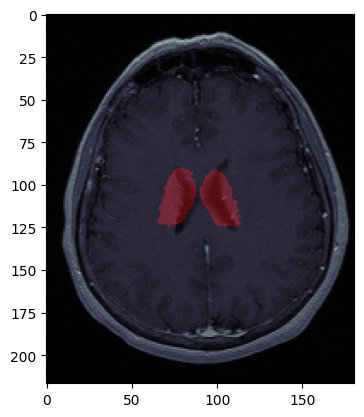

In [79]:
mask_centroid = find_centroid_volume(mask)
visualize_axial_slice(patient_image.pixel_array[6:-6, 6:-6, 6:-6], mask, mask_centroid)

C:\Users\iulhaq\AppData\Local\Temp\ipykernel_25080\2541192507.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('bone')


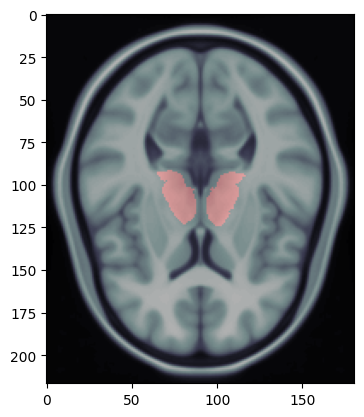

In [80]:
visualize_axial_slice(reference_image.pixel_array[6:-6, 6:-6, 6:-6], mask_reference, mask_centroid)